# Import

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import itertools
import keras
import keras_tuner as kt

from random import gauss
from random import seed

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, root_mean_squared_error,r2_score

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from arch import arch_model

from pmdarima import auto_arima
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from keras_tuner import Hyperband
from keras.models import load_model,Sequential

In [3]:
df = pd.read_csv('../data/cleaned_data/master.csv',index_col=0)
df.head()

,nonglu_price,hommali_price,agri_prod_index,crops_prod_index,paddy_prod_index,nonglu_prod_index,hommali_prod_index,agri_price_index,crops_price_index,paddy_price_index,...,water_station_M7,water_station_N1,water_station_N67,water_station_Ny1B,water_station_P1,water_station_P17,water_station_S4B,water_station_Sw5A,water_station_Y17,water_station_Y1C
date,,,,,,,,,,,,,,,,,,,,,
2006-01-01,6696.0,7628.0,109.703894,114.011647,43.580672,72.649707,8.077559,110.377654,113.821771,100.581118,...,140.50,66.17,520.00,26.85,38.96,679.63,6.23,97.92,1.24,20.25
2006-02-01,6633.0,7873.0,93.049409,91.755084,46.062229,85.832560,0.000000,111.337228,115.390439,101.563145,...,87.75,39.02,501.32,26.22,64.11,573.91,4.69,69.55,0.00,13.07
2006-03-01,6649.0,7960.0,92.803780,87.828340,74.516499,138.854375,0.000000,112.498075,117.876876,103.063764,...,108.95,20.94,558.72,42.23,68.26,523.38,2.23,60.02,2.32,35.51
2006-04-01,6880.0,8028.0,75.452369,67.662286,66.215260,123.385807,0.000000,115.595159,121.878356,104.906097,...,188.40,45.73,692.79,61.08,84.68,508.65,0.06,76.80,5.84,31.54
2006-05-01,6782.0,8069.0,77.366260,68.992476,35.785484,66.682829,0.000000,113.408937,119.725058,104.687875,...,270.30,94.19,1027.25,44.98,146.19,1092.68,34.64,88.76,168.17,268.37


In [4]:
# Set index as datetime
df.index = pd.to_datetime(df.index,format="%Y-%m-%d")

In [5]:
# Check type of value
df.dtypes.value_counts()

float64    49
Name: count, dtype: int64

In [6]:
df.shape

(226, 49)

In [7]:
df.columns

Index(['nonglu_price', 'hommali_price', 'agri_prod_index', 'crops_prod_index',
       'paddy_prod_index', 'nonglu_prod_index', 'hommali_prod_index',
       'agri_price_index', 'crops_price_index', 'paddy_price_index',
       'nonglu_price_index', 'hommali_price_index', 'agri_export_value',
       'rice_export_value', 'rice_export_amount', 'inflation', 'cpi_rice',
       'pol_rate', 'neer', 'reer', 'sirikit_water', 'bhumibol_water',
       'fertilizer_1', 'fertilizer_2', 'fertilizer_3', 'fertilizer_4',
       'fertilizer_5', 'fertilizer_6', 'water_station_B10',
       'water_station_C13', 'water_station_C2', 'water_station_G8',
       'water_station_K10', 'water_station_K11A', 'water_station_Kgt3',
       'water_station_Kh103', 'water_station_Kh58A', 'water_station_Kh72',
       'water_station_M6A', 'water_station_M7', 'water_station_N1',
       'water_station_N67', 'water_station_Ny1B', 'water_station_P1',
       'water_station_P17', 'water_station_S4B', 'water_station_Sw5A',
       'w

# Model

In [9]:
# Create the target
y = df['nonglu_price']

# Define independent variables (predictors) X
xvars_all = ['agri_prod_index', 'crops_prod_index','paddy_prod_index', 'nonglu_prod_index', 'hommali_prod_index',
             'agri_export_value', 'rice_export_value','rice_export_amount', 
             'inflation', 'pol_rate', 'neer', 'reer','inflation' , 'cpi_rice',
             'fertilizer_1', 'fertilizer_2', 'fertilizer_3', 'fertilizer_4','fertilizer_5', 'fertilizer_6', 
             'sirikit_water', 'bhumibol_water',
             'water_station_B10','water_station_C13', 'water_station_C2', 'water_station_G8',
             'water_station_K10', 'water_station_K11A', 'water_station_Kgt3',
             'water_station_Kh103', 'water_station_Kh58A', 'water_station_Kh72',
             'water_station_M6A', 'water_station_M7', 'water_station_N1',
             'water_station_N67', 'water_station_Ny1B', 'water_station_P1',
             'water_station_P17', 'water_station_S4B', 'water_station_Sw5A',
             'water_station_Y17', 'water_station_Y1C']

# Adjust X to match the same periods
X = df[xvars_all]

In [10]:
# Split data into training and test sets
# shuffle=False maintains time order (crucial for time series!)
# test_size=20 reserves last 20 observations for testing

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=25)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((201, 43), (25, 43), (201,), (25,))

## 1. Linear Regression Model

### Model 1: Linear Regression Model

In [14]:
label = 'nonglu_price'
df = df[xvars_all + [label]]

train_data = df[df.index < '2022-10-01']
test_data = df[df.index >= '2022-10-01']

X_train = train_data.drop(columns=['nonglu_price'])
y_train = train_data['nonglu_price']

X_test = test_data.drop(columns=['nonglu_price'])
y_test = test_data['nonglu_price']

In [16]:
# Instantiate and fit an Linear model
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [17]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((201, 47), (25, 47), (201,), (25,))

In [18]:
# Prediction
y_pred = lr.predict(X_test)

In [19]:
# Evaluate the Linear Regression Model
lr_mse = mean_squared_error(y_test, y_pred)
lr_rmse = root_mean_squared_error(y_test, y_pred)
lr_r2 = r2_score(y_test, y_pred)
print(f"Linear Regression Model MSE: {lr_mse:.4f}")
print(f"Linear Regression Model RMSE: {lr_rmse:.4f}")
print(f"Linear Regression Model R-squared: {lr_r2:.4f}")

Linear Regression Model MSE: 2206168.8899
Linear Regression Model RMSE: 1485.3178
Linear Regression Model R-squared: -1.0061


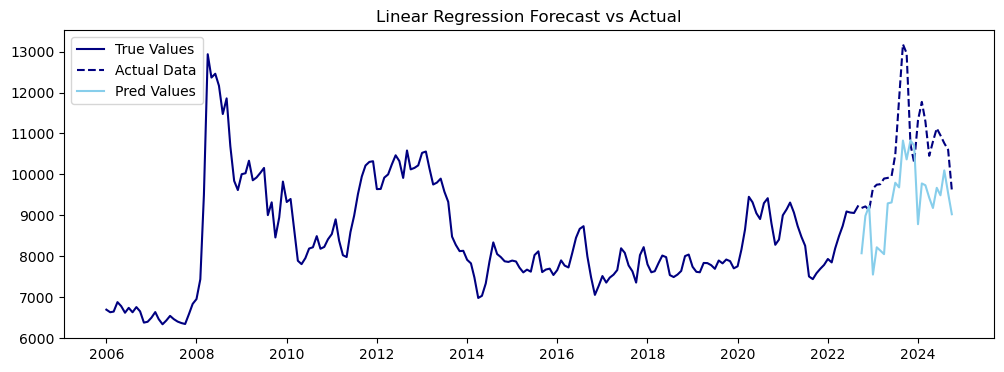

In [20]:
# Plot predictions
plt.figure(figsize=(12, 4))
plt.plot(y_train, c='navy', label='True Values')
plt.plot(y_test, c='navy', linestyle='dashed', label="Actual Data")
plt.plot(test_data.index,y_pred, c='skyblue', label='Pred Values')
plt.title("Linear Regression Forecast vs Actual")
plt.legend()

# saving the plot as an image
plt.savefig('../figure/all/Linear Regression Forecast vs Actual.png')
plt.show()

#### Feature importance

In [22]:
#print regression coefficients
lr_coef = pd.DataFrame(zip(X.columns, lr.coef_))
lr_coef

,0,1
0,agri_prod_index,20.972254
1,crops_prod_index,-19.986251
2,paddy_prod_index,-2.309630
3,nonglu_prod_index,1.572600
4,hommali_prod_index,1.610962
5,agri_export_value,-0.090764
6,rice_export_value,8.778891
7,rice_export_amount,-0.004188
8,inflation,-27.283124
9,pol_rate,97.037368


## 2. ARIMA Model

### Model 2 : ARIMA

In [25]:
# Fit an ARIMA model with exogenous variables (also called ARIMAX)
y_train.index.freq = 'MS'
X_train.index.freq = 'MS'

arimax1_model = ARIMA(
    y_train,                 # Dependent variable (nonglu_price)
    exog=X_train,            # External variables 
    order=(2, 1, 2)).fit()   # ARIMA parameters: (p=2, d=1, q=2)

In [26]:
# Generate predictions on the test set
arimax1_forecast = arimax1_model.predict(
   start=X_test.index[0],    # Start forecasting from first test observation
   end=X_test.index[-1],     # Continue until last test observation
   exog=X_test)

In [27]:
# Evaluate the ARIMAX(2,1,2) Model
arimax1_mse = mean_squared_error(y_test, arimax1_forecast)
arimax1_rmse = root_mean_squared_error(y_test, arimax1_forecast)
arimax1_r2 = r2_score(y_test, arimax1_forecast)
print(f"ARIMAX(2,1,2) Model MSE : {arimax1_mse:.4f}")
print(f"ARIMAX(2,1,2) Model RMSE :{arimax1_rmse:.4f}")
print(f"ARIMAX(2,1,2) Model R-squared :{arimax1_r2:.4f}")

ARIMAX(2,1,2) Model MSE : 1187409.6912
ARIMAX(2,1,2) Model RMSE :1089.6833
ARIMAX(2,1,2) Model R-squared :-0.0797


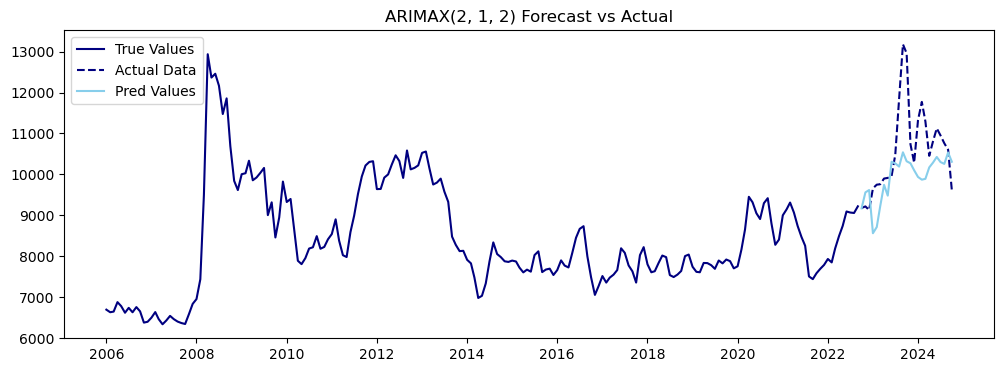

In [28]:
# Plot 
plt.figure(figsize=(12, 4))
plt.plot(y_train, c='navy', label='True Values')
plt.plot(y_test, c='navy', linestyle='dashed', label="Actual Data")
plt.plot(arimax1_forecast, c='skyblue', label='Pred Values')
plt.title("ARIMAX(2, 1, 2) Forecast vs Actual")
plt.legend()

# saving the plot as an image
plt.savefig('../figure/all/ARIMAX(2,1,2) Forecast vs Actual.png')
plt.show()

#### Feature Importance

In [30]:
arimax1_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           nonglu_price   No. Observations:                  201
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1422.284
Date:                Thu, 19 Dec 2024   AIC                           2948.568
Time:                        16:28:03   BIC                           3120.080
Sample:                    01-01-2006   HQIC                          3017.976
                         - 09-01-2022                                         
Covariance Type:                  opg                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
agri_prod_index       -11.9035     14.695     -0.810      0.418     -40.706      16.899
crops_prod_index        6.3166     10.867      0.581      0.561     -14.981      27.615
paddy_prod_index        3.1517      2.720      1.159      0.247      -2.179       8.482
nonglu_prod_index      -2.6868      1.714     -1.568      0.117      -6.046       0.672
hommali_prod_index     -0.7178      0.952     -0.754      0.451      -2.585       1.149
agri_export_value       0.3240      0.236      1.373      0.170      -0.139       0.786
rice_export_value       2.3469      1.173      2.001      0.045       0.048       4.646
rice_export_amount     -0.0012      0.001     -2.227      0.026      -0.002      -0.000
inflation             -17.7363     52.756     -0.336      0.737    -121.136      85.664
pol_rate              320.4785    258.639      1.239      0.215    -186.444     827.401
neer                   -1.6071    105.367     -0.015      0.988    -208.123     204.909
reer                   22.0419    105.962      0.208      0.835    -185.640     229.724
inflation             -17.7363     52.756     -0.336      0.737    -121.136      85.664
cpi_rice               53.0734     31.123      1.705      0.088      -7.927     114.074
fertilizer_1           -0.0622      0.101     -0.618      0.537      -0.259       0.135
fertilizer_2           -0.0311      0.059     -0.525      0.600      -0.147       0.085
fertilizer_3           -0.0513      0.112     -0.457      0.648      -0.271       0.169
fertilizer_4           -0.0123      0.039     -0.312      0.755      -0.090       0.065
fertilizer_5            0.1746      0.089      1.956      0.051      -0.000       0.350
fertilizer_6            0.0690      0.067      1.036      0.300      -0.062       0.200
sirikit_water           0.9509      0.541      1.758      0.079      -0.109       2.011
bhumibol_water         -0.2090      0.168     -1.243      0.214      -0.539       0.121
water_station_B10       0.1256      1.118      0.112      0.911      -2.067       2.318
water_station_C13      -0.0242      0.116     -0.209      0.834      -0.251       0.203
water_station_C2        0.1140      0.161      0.707      0.480      -0.202       0.430
water_station_G8       -1.1949      1.596     -0.749      0.454      -4.323       1.933
water_station_K10      -0.1659      0.201     -0.826      0.409      -0.560       0.228
water_station_K11A      0.0154      0.221      0.070      0.944      -0.418       0.449
water_station_Kgt3      0.2271      0.235      0.965      0.335      -0.234       0.689
water_station_Kh103     1.4156      2.088      0.678      0.498      -2.676       5.508
water_station_Kh58A    -0.4900      0.450     -1.088      0.277      -1.373       0.393
water_station_Kh72     -1.4503      3.146     -0.461      0.645      -7.616       4.716
water_station_M6A      -0.0991      0.134     -0.738      0.461      -0.363       0.164
water_station_M7       -0.0413      0.044     -0.943      0.346      -0.1

### Model 3 : Auto ARIMA

In [32]:
# Automatically tune ARIMA parameters
auto_model = auto_arima(
    y_train,exogenous=X_train,
    start_p=0, max_p=4,
    start_q=0, max_q=4,
    d=None,seasonal=False, trace=False,error_action='ignore', suppress_warnings=True, stepwise=True)

# Best parameters
print(auto_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  201
Model:               SARIMAX(2, 0, 0)   Log Likelihood               -1497.527
Date:                Thu, 19 Dec 2024   AIC                           3003.053
Time:                        16:28:03   BIC                           3016.267
Sample:                    01-01-2006   HQIC                          3008.400
                         - 09-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    675.8081    219.037      3.085      0.002     246.504    1105.112
ar.L1          1.2125      0.031     39.511      0.000       1.152       1.273
ar.L2         -0.2931      0.038     -7.801      0.0

In [33]:
# Fit an ARIMA model with exogenous variables (also called ARIMAX)
y_train.index.freq = 'MS'
X_train.index.freq = 'MS'

arimax2_model = ARIMA(
    y_train,           # Dependent variable (nonglu_price)
    exog = X_train,    # External variables 
    order = (2, 0, 0), # ARIMA parameters: (p=2, d=0, q=0)
).fit()

# Get the residual
arimax2_model_residuals = arimax2_model.resid

# Generate predictions on the test set
arimax2_forecast = arimax2_model.predict(
   start=X_test.index[0],    # Start forecasting from first test observation
   end=X_test.index[-1],     # Continue until last test observation
   exog=X_test)

In [34]:
# Evaluate the ARIMAX(2,0,0) Model
arimax2_mse = mean_squared_error(y_test, arimax2_forecast)
arimax2_rmse = root_mean_squared_error(y_test, arimax2_forecast)
arimax2_r2 = r2_score(y_test, arimax2_forecast)
print(f"ARIMAX(2,0,0) Model MSE : {arimax2_mse:.4f}")
print(f"ARIMAX(2,0,0) Model RMSE :{arimax2_rmse:.4f}")
print(f"ARIMAX(2,0,0) Model R-squared :{arimax2_r2:.4f}")

ARIMAX(2,0,0) Model MSE : 1951929.4253
ARIMAX(2,0,0) Model RMSE :1397.1147
ARIMAX(2,0,0) Model R-squared :-0.7749


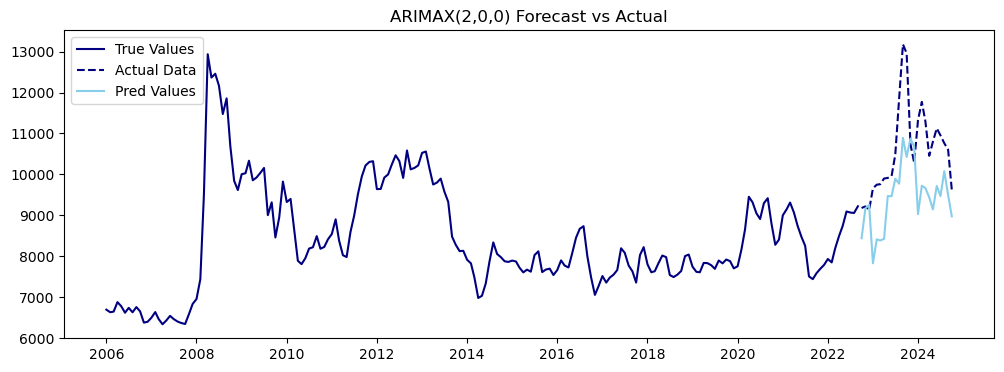

In [35]:
# Plot 
plt.figure(figsize=(12, 4))
plt.plot(y_train, c='navy', label='True Values')
plt.plot(y_test, c='navy', linestyle='dashed', label="Actual Data")
plt.plot(arimax2_forecast, c='skyblue', label='Pred Values')
plt.title("ARIMAX(2,0,0) Forecast vs Actual")
plt.legend()

# saving the plot as an image
plt.savefig('../figure/all/ARIMAX(2,0,0) Forecast vs Actual.png')
plt.show()

#### Feature Importance

In [37]:
arimax2_model.summary()

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/mlemodel.py:3014: RuntimeWarning: invalid value encountered in divide
  return self.params / self.bse


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           nonglu_price   No. Observations:                  201
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -1480.675
Date:                Thu, 19 Dec 2024   AIC                           3063.350
Time:                        16:28:09   BIC                           3231.819
Sample:                    01-01-2006   HQIC                          3131.520
                         - 09-01-2022                                         
Covariance Type:                  opg                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                1.167e+04     26.212    445.242      0.000    1.16e+04    1.17e+04
agri_prod_index        20.9715     20.561      1.020      0.308     -19.328      61.271
crops_prod_index      -19.9862     14.806     -1.350      0.177     -49.006       9.033
paddy_prod_index       -2.3081      4.172     -0.553      0.580     -10.486       5.870
nonglu_prod_index       1.5755      2.727      0.578      0.563      -3.770       6.921
hommali_prod_index      1.6080      1.549      1.038      0.299      -1.427       4.643
agri_export_value      -0.0984      0.284     -0.346      0.729      -0.656       0.459
rice_export_value       8.7721      1.299      6.755      0.000       6.227      11.317
rice_export_amount     -0.0040      0.001     -6.061      0.000      -0.005      -0.003
inflation             -27.2840     13.610     -2.005      0.045     -53.959      -0.609
pol_rate               97.0374    174.666      0.556      0.579    -245.302     439.377
neer                   72.4455     34.768      2.084      0.037       4.301     140.590
reer                  -94.4230     44.586     -2.118      0.034    -181.809      -7.037
inflation             -27.2840     13.610     -2.005      0.045     -53.959      -0.609
cpi_rice              119.3733     21.442      5.567      0.000      77.348     161.398
fertilizer_1            0.1793      0.094      1.903      0.057      -0.005       0.364
fertilizer_2           -0.0241      0.047     -0.513      0.608      -0.116       0.068
fertilizer_3            0.1631      0.119      1.365      0.172      -0.071       0.397
fertilizer_4            0.0920      0.057      1.619      0.106      -0.019       0.203
fertilizer_5           -0.0286      0.099     -0.288      0.773      -0.224       0.166
fertilizer_6           -0.1433      0.077     -1.853      0.064      -0.295       0.008
sirikit_water           0.8157      0.842      0.969      0.333      -0.835       2.466
bhumibol_water         -0.1775      0.288     -0.616      0.538      -0.742       0.387
water_station_B10      -4.0152      1.586     -2.532      0.011      -7.123      -0.908
water_station_C13      -0.0557      0.159     -0.349      0.727      -0.368       0.257
water_station_C2        0.0322      0.246      0.131      0.896      -0.450       0.515
water_station_G8        2.2552      2.567      0.878      0.380      -2.777       7.287
water_station_K10      -0.3014      0.308     -0.978      0.328      -0.905       0.302
water_station_K11A      0.3133      0.325      0.963      0.336      -0.324       0.951
water_station_Kgt3      0.4221      0.311      1.357      0.175      -0.187       1.032
water_station_Kh103     0.0604      3.887      0.016      0.988      -7.557       7.678
water_station_Kh58A    -0.6224      0.987     -0.631      0.528      -2.557       1.312
water_station_Kh72     -3.5431      4.690     -0.755      0.450     -12.736       5.649
water_station_M6A      -0.0346      0.236     -0.146      0.884      -0.4

## 4. GARCH Model

### Model 4 : GARCH

In [40]:
# Seed pseudorandom number generator
seed(1)

# Define model - fit on the residuals.
garch_model = arch_model(arimax2_model_residuals,mean='HARX', vol='GARCH', p=1, q=1, rescale=False)

# Fit model
garch_model_fit = garch_model.fit(disp='off')

# forecast the test set
garch_forecast = garch_model_fit.forecast(horizon=len(y_test), reindex=False)
garch_volatility = np.sqrt(garch_forecast.variance.values[-1])  # Convert to standard deviation

arimax_forecast = arimax2_model.get_forecast(steps=len(y_test), exog=X_test)
arimax_mean = arimax_forecast.predicted_mean

# combine ARIMAX Mean and GARCH Volatility
yhat = arimax_mean + garch_volatility  # Add GARCH volatility directly

In [41]:
# Evaluate the GARCH Model
garch_mse = mean_squared_error(y_test, yhat)
garch_rmse = root_mean_squared_error(y_test, yhat)
garch_r2 = r2_score(y_test, yhat)

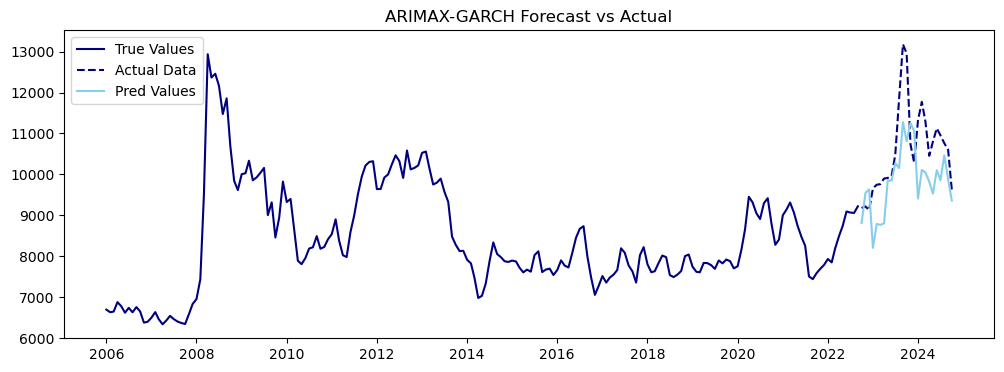

In [42]:
# Plot
plt.figure(figsize=(12, 4))
plt.plot(y_train, c='navy', label="True Values")
plt.plot(y_test.index, y_test, c='navy', linestyle='dashed', label="Actual Data")
plt.plot(y_test.index, yhat, c='skyblue', label="Pred Values")
plt.legend()
plt.title("ARIMAX-GARCH Forecast vs Actual")

# saving the plot as an image
plt.savefig('../figure/all/ARIMAX-GARCH Forecast vs Actual.png')
plt.show()

#### Feature Importance

In [44]:
print('GARCH Coefficients:')
print('omega (constant):', garch_model_fit.params['omega'])
print('alpha (ARCH term):', garch_model_fit.params['alpha[1]'])
print('beta (GARCH term):', garch_model_fit.params['beta[1]'])

GARCH Coefficients:
omega (constant): 14611.585682412433
alpha (ARCH term): 0.1287337808899676
beta (GARCH term): 0.7738645636579159


# Compare the score of models

In [46]:
score_df = pd.DataFrame(data = {'feature' : ['all'] * 3,
                                'model': ['Linear','ARIMAX(2,0,0)','GARCH'] , 
                                'MSE': [lr_mse,arimax2_mse,garch_mse], 
                                'RMSE': [lr_rmse,arimax2_rmse,garch_rmse], 
                                'R2': [lr_r2,arimax2_r2,garch_r2]})
score_df.to_csv('../data/cleaned_data/evaluation/all.csv',index=False)
score_df

,feature,model,MSE,RMSE,R2
0,all,Linear,2.206169e+06,1485.317774,-1.006066
1,all,"ARIMAX(2,0,0)",1.951929e+06,1397.114679,-0.774887
2,all,GARCH,1.225103e+06,1106.843834,-0.113985


In [79]:
score_df = pd.DataFrame(data = {'feature' : ['all'] * 3,
                                'model': ['Linear','ARIMAX(2,0,0)','GARCH'] , 
                                'MSE': [lr_mse,arimax2_mse,garch_mse], 
                                'RMSE': [lr_rmse,arimax2_rmse,garch_rmse], 
                                'R2': [lr_r2,arimax2_r2,garch_r2]})
score_df.to_csv('../data/cleaned_data/evaluation/all.csv',index=False)
score_df

,feature,model,MSE,RMSE,R2
0,all,Linear,2.206169e+06,1485.317774,-1.006066
1,all,"ARIMAX(2,0,0)",1.951929e+06,1397.114679,-0.774887
2,all,GARCH,1.225103e+06,1106.843834,-0.113985
